In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import re

import tensorflow as tf

In [ ]:
df.fillna('').astype(str).apply(lambda x:x.str.len()).max()

ID           11
sequence    993
label         3
dtype: int64

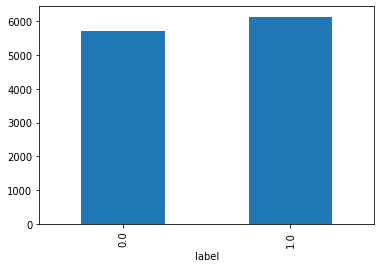

In [ ]:
df.groupby('label').size().plot.bar()
plt.show()

In [ ]:
# Tokenize from characters to integers (sequences and then pad / truncate data)

df_tok = df.copy()
maxlen = 1000 # cut off after this number of characters in a string

max_words = 22 
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer.fit_on_texts(list(df_tok['sequence']))
sequences = tokenizer.texts_to_sequences(list(df_tok['sequence']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)


print('Found %s unique tokens.' % len(word_index))
print('word_index', word_index)

Found 22 unique tokens.
word_index {'l': 1, 'a': 2, 'g': 3, 'v': 4, 'i': 5, 's': 6, 't': 7, 'e': 8, 'r': 9, 'k': 10, 'f': 11, 'd': 12, 'p': 13, 'q': 14, 'n': 15, 'y': 16, 'm': 17, 'h': 18, 'w': 19, 'c': 20, 'x': 21, 'z': 22}


In [ ]:
labels = np.asarray(df_tok['label'])
print(Xpad.shape)
print(labels.shape)

(11846, 1000)
(11846,)


In [ ]:
rowNum = 10000
print(df_tok['sequence'][rowNum])
print(sequences[rowNum])
print(Xpad[rowNum])
print(labels[rowNum])

MVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCSTSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGTMTLAELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGDPRDTTTPRAMAQTLRQLTLGHALGETQRAQLVTWLKGNTTGAASIRAGLPTSWTVGDKTGSGGYGTTNDIAVIWPQGRAPLVLVTYFTQPQQNAESRRDVLASAARIIAEGL
[17, 4, 7, 10, 9, 4, 14, 9, 17, 17, 11, 2, 2, 2, 2, 20, 5, 13, 1, 1, 1, 3, 6, 2, 13, 1, 16, 2, 14, 7, 6, 2, 4, 14, 14, 10, 1, 2, 2, 1, 8, 10, 6, 6, 3, 3, 9, 1, 3, 4, 2, 1, 5, 12, 7, 2, 12, 15, 7, 14, 4, 1, 16, 9, 3, 12, 8, 9, 11, 13, 17, 20, 6, 7, 6, 10, 4, 17, 2, 2, 2, 2, 4, 1, 10, 14, 6, 8, 7, 14, 10, 14, 1, 1, 15, 14, 13, 4, 8, 5, 10, 13, 2, 12, 1, 4, 15, 16, 15, 13, 5, 2, 8, 10, 18, 4, 15, 3, 7, 17, 7, 1, 2, 8, 1, 6, 2, 2, 2, 1, 14, 16, 6, 12, 15, 7, 2, 17, 15, 10, 1, 5, 2, 14, 1, 3, 3, 13, 3, 3, 4, 7, 2, 11, 2, 9, 2, 5, 3, 12, 8, 7, 11, 9, 1, 12, 9, 7, 8, 13, 7, 1, 15, 7, 2, 5, 13, 3, 12, 13, 9, 12, 7, 7, 7, 13, 9, 2, 17, 2, 14, 7, 1, 9, 14, 1, 7, 1, 3, 18, 2, 1, 3, 8, 7, 14, 9, 2, 14, 1, 4, 7,

In [ ]:
training_samples = int(Xpad.shape[0] * 0.9)

indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) 

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (10661, 1000)
y_train (10661,)
x_test (1185, 1000)
y_test (1185,)


In [ ]:
model = Sequential()
model.add(Embedding(22, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(9))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 1)           22        
                                                                 
 conv1d_2 (Conv1D)           (None, 974, 128)          3584      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 108, 128)         0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 108, 128)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 128)          147584    
                                                                 
 dropout_3 (Dropout)         (None, 100, 128)          0         
                                                      

In [ ]:
history = model.fit(x_train, y_train,
epochs = 10,
batch_size=32,
validation_split=0.2)

Epoch 1/10
267/267 [==============================] - 110s 388ms/step - loss: 0.4460 - acc: 0.7880 - val_loss: 0.3176 - val_acc: 0.8664
Epoch 2/10
267/267 [==============================] - 102s 383ms/step - loss: 0.2726 - acc: 0.8911 - val_loss: 0.2959 - val_acc: 0.8856
Epoch 3/10
267/267 [==============================] - 101s 379ms/step - loss: 0.2085 - acc: 0.9194 - val_loss: 0.1844 - val_acc: 0.9259
Epoch 4/10
267/267 [==============================] - 101s 377ms/step - loss: 0.1796 - acc: 0.9329 - val_loss: 0.1602 - val_acc: 0.9339
Epoch 5/10
267/267 [==============================] - 102s 381ms/step - loss: 0.1584 - acc: 0.9409 - val_loss: 0.1598 - val_acc: 0.9339
Epoch 6/10
267/267 [==============================] - 101s 380ms/step - loss: 0.1494 - acc: 0.9457 - val_loss: 0.1625 - val_acc: 0.9437
Epoch 7/10
267/267 [==============================] - 100s 374ms/step - loss: 0.1319 - acc: 0.9505 - val_loss: 0.1257 - val_acc: 0.9550
Epoch 8/10
267/267 [============================

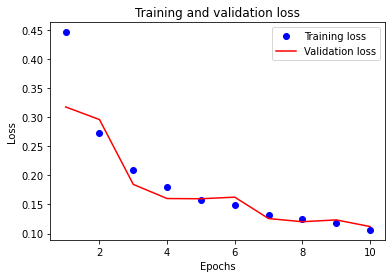

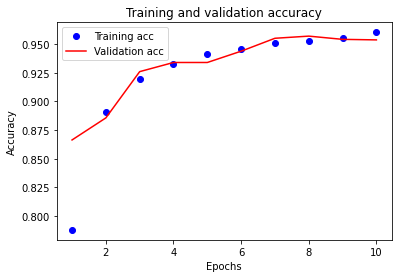

In [ ]:
plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
final_predictions = model.predict(x_test)
print(final_predictions)

Preds = final_predictions.copy()
print(len(Preds))

Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

38/38 [==============================] - 2s 57ms/step
[[9.9861193e-01]
 [9.8962390e-01]
 [4.3188315e-02]
 ...
 [1.4516422e-01]
 [9.9531901e-01]
 [8.3564461e-05]]
1185
[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


In [ ]:
conf_mx = confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  564
FP:  28
FN:  24
TP:  569
0.9595278246205734 0.9530988274706867


In [ ]:
print ('precision ',precision_score(y_test, Preds))
print ('recall ',recall_score(y_test, Preds) )
print ('accuracy ',accuracy_score(y_test, Preds))
print ('F1 score ',f1_score(y_test, Preds))

precision  0.9530988274706867
recall  0.9595278246205734
accuracy  0.9561181434599156
F1 score  0.9563025210084035


AUC: 0.956


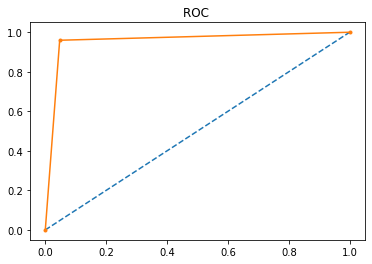

In [ ]:
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()